In [1]:
# I will only use a 'fake' brain for this one, only results are actions 0 - 4
# This means I will start with an untrained text_dec and text_enc (though I will steal the img_enc from the old brain)
# If this proves too hard, I will start with an easier task

# This notebook will attempt actual PPO as a test study.
# If I want this for the actual system, I may use a 'burn-in' phase which includes making the relevant actions have non-negligible probability,
# and THEN launching the PPO

In [2]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings) # kind of a waste; will only call this object to generate random versions of itself

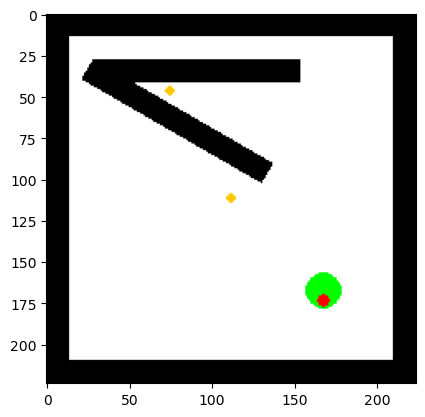

In [4]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [5]:
from RL_helper import *

In [6]:
from visual_transformer import *
device = torch.device('cuda:0') # retrying on the 2080 after patching memory leak

In [7]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [8]:
# Ok, on to RL-specifics things

In [9]:
symbol_action_map

{1: 1, 3: 3, 4: 4, 108: 2}

In [10]:
# THis work for the full brain, but I am rewriting this for this experiment

In [11]:
symbol_action_map = {1: 1, 2: 2, 3: 3, 4: 4}
symbol_action_map

{1: 1, 2: 2, 3: 3, 4: 4}

In [12]:
# Next, I need to set up the brain itself
old_brain = DefaultAgentBrain()
old_brain.load_state_dict(torch.load('brain_checkpoints/brain_weights_tutorial1_v3_batch95000.pth', weights_only=True, map_location='cpu'))

brain = DefaultAgentBrain(5)
brain.img_enc = old_brain.img_enc
brain.img_dec = old_brain.img_dec
brain = brain.to(device)

In [13]:
# I'm starting to regret feeding the traces in at all
# I should really just have a single 'prompt' like "what is the best action here?"
# However, I don't feel like rewriting RL_helper just for this experiment, so this is what we are dealing with.
# Hopefully PPO will still work.

In [14]:
#buff = GameOutputBuffer(brain, brain.evaluate_text, gamma=0.99, tau=0.97, default_batch_size=8)

In [15]:
#buff.get_device()

In [16]:
#buff.fill(G)

In [17]:
#buff.__dict__

In [18]:
#buff = buff.to('cpu')

In [19]:
#buff.__dict__

In [20]:
def get_bb(num_buffers=64, batch_size=1):
    bb = []
    brain.eval()
    for i in range(num_buffers):
        #print(i)
        # In this case, we are only training the 'dopamine' layer on the val training loop
        buff = GameOutputBuffer(brain, brain.evaluate_text, gamma=0.99, tau=0.97, default_batch_size=batch_size)
        buff.fill(G, num_games=batch_size)
        buff.cpu()
        bb.append(buff)
    return bb

In [21]:
bb = get_bb(64)

In [22]:
mse_loss = nn.MSELoss()

In [23]:
# Only training the dopamine module here; img_enc is frozen, and hopefully it'll learn to largely ignore text_enc
val_optimizer = optim.Adam(brain.dopamine.parameters(), lr=0.00001, eps=1e-9)
val_epochs = 16 #16 # old is 80, but that's only sampling a few per turn; we're gonna go through the whole buffer-buffer

In [24]:
#brain.train()

In [25]:
#brain.training

In [26]:
#buff = bb[0]
#buff

In [27]:
#buff.to(device)
#buff

In [28]:
#buff.__dict__

In [29]:
#val_optimizer.zero_grad()

In [30]:
#new_vals = buff.get_values(evaluation = False)

In [31]:
#loss = mse_loss(new_vals, buff.returns)

In [32]:
#loss.backward()

In [33]:
#val_optimizer.step()

In [34]:
#val_optimizer.zero_grad()

In [35]:
#brain.eval()

In [36]:
#bb[1].cpu()

In [37]:
#loss

In [38]:
#bb[1].returns.grad

In [39]:
torch.cuda.memory_allocated() / (1024 ** 3)

0.6456818580627441

In [40]:
def nvidia_smi_spoof(device=device):
    return torch.cuda.memory_allocated() / (1024 ** 3)

In [41]:
import random
def train_val_func(val_optimizer, epochs, buffer_buffer):
    for epoch in range(epochs):
        print(f"==========Epoch {epoch}=====================")
        #print(nvidia_smi_spoof())
        brain.train()
        #print(nvidia_smi_spoof())
        train_loss = 0
        random.shuffle(buffer_buffer)
        i = 0
        for buffer in buffer_buffer:
            i += 1
            #print(nvidia_smi_spoof())
            buffer.to(device)
            #print(nvidia_smi_spoof())
            val_optimizer.zero_grad()
            #print(nvidia_smi_spoof())
            # call value func with dopamine gradients (and no others)
            new_vals = buffer.get_values(evaluation = False, img_gradient = False, text_gradient = False)
            #print(nvidia_smi_spoof())
            loss = mse_loss(new_vals, buffer.returns)
            #print(nvidia_smi_spoof())
            loss.backward()
            #print(nvidia_smi_spoof())
            val_optimizer.step()
            #print(nvidia_smi_spoof())
            train_loss += loss.item()
            #print(nvidia_smi_spoof())
            print(f"episode {i}, val func loss {loss.item()}\n")
            #print(nvidia_smi_spoof())
            buffer.cpu()
            #print(nvidia_smi_spoof())
        val_optimizer.zero_grad()
        #print(nvidia_smi_spoof())
        print(f"Val func train loss in epoch {epoch}:{train_loss / (len(buffer_buffer))}")
#train_val_func(val_optimizer, val_epochs, buffer_buffer)

In [42]:
#train_val_func(val_optimizer, 1, bb)

In [43]:
#brain.text_enc.embed[0].weight.grad

In [44]:
buff = bb[5]

In [45]:
buff.__dict__

{'seed_offset': 1,
 'tau': 0.97,
 'gamma': 0.99,
 'default_batch_size': 1,
 'contexts': None,
 'logpas': tensor([[-1.3678, -1.5493, -2.5793, -1.1511]]),
 'traces': tensor([[0, 1, 3, 4, 2]]),
 'settings_buffer': [[<game.levels.skeleton.Settings at 0x7ff1b13916d0>,
 'games': [<game.discreteEngine.discreteGame at 0x7ff1b1393dd0>],
 'entropies': tensor([[1.5309, 1.5081, 1.5177, 1.5152]]),
 'gaes': tensor([[2.1568, 1.9536, 2.2717, 1.0638]]),
 'terminated': tensor([[False, False, False, False,  True]]),
 'past_terminated': tensor([[False, False, False, False, False]]),
 'values': tensor([[0.0000, 0.2836, 0.0562, 1.3196, 2.4075]]),
 'rewards': tensor([[0., 0., 0., 0., 0.]]),
 'returns': tensor([[0., 0., 0., 0., 0.]]),
 'policy_model': DefaultAgentBrain(
   (img_enc): ImageTransformerEncoder(
     (embed): Sequential(
       (0): PatchEmbedding(
         (linear_project): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
       )
       (1): PositionalEncoding_2D()
       (2): LayerNorm((7

In [46]:

for key in buff.tensor_keys:
    print(key)
    if buff.__dict__[key] is not None:
        print(buff.__dict__[key])
        if buff.__dict__[key].grad is not None:
            print("found a suspect")
            print(buff.__dict__[key].grad)
    print('\n\n')


contexts



logpas
tensor([[-1.3678, -1.5493, -2.5793, -1.1511]])



traces
tensor([[0, 1, 3, 4, 2]])



entropies
tensor([[1.5309, 1.5081, 1.5177, 1.5152]])



gaes
tensor([[2.1568, 1.9536, 2.2717, 1.0638]])



terminated
tensor([[False, False, False, False,  True]])



past_terminated
tensor([[False, False, False, False, False]])



values
tensor([[0.0000, 0.2836, 0.0562, 1.3196, 2.4075]])



rewards
tensor([[0., 0., 0., 0., 0.]])



returns
tensor([[0., 0., 0., 0., 0.]])



discounts
tensor([1.0000, 0.9897, 0.9795, 0.9694, 0.9594, 0.9495, 0.9397, 0.9300, 0.9204,
        0.9109, 0.9015, 0.8923, 0.8831, 0.8739, 0.8649, 0.8560, 0.8472, 0.8385,
        0.8298, 0.8213, 0.8128, 0.8044, 0.7961, 0.7879, 0.7798, 0.7717, 0.7638,
        0.7559, 0.7481, 0.7404, 0.7328, 0.7252, 0.7177])



tau_discounts
tensor([1.0000, 0.9591, 0.9198, 0.8822, 0.8461, 0.8115, 0.7783, 0.7464, 0.7159,
        0.6866, 0.6585, 0.6316, 0.6057, 0.5810, 0.5572, 0.5344, 0.5125, 0.4916,
        0.4714, 0.4522, 0.4337, 0.

In [47]:
brain.dopamine.fc[0].weight.grad

In [48]:
brain.text_enc.embed[0].weight.grad

In [49]:
brain.text_dec.fc[0].weight.grad

In [50]:
# ok. I think there's some noise in the values returned by nvidia-smi and the cuda func (slow deallocation?)
# but it really looks like I squashed both sources of memory leaks.
# Let's try this again, but with big-boy parameters

In [51]:
# let's recalculate gaes after burn-in, to get any progress on the policy network at all
def restore_coherence(buffer_buffer):
    for buffer in buffer_buffer:
        buffer=buffer.cuda()
        buffer.values = buffer.get_values() # retrained val func
        buffer.gaes = buffer.get_gaes()
        buffer = buffer.cpu()
    return buffer_buffer
#buffer_buffer = restore_coherence(buffer_buffer)

In [52]:
policy_optimizer = optim.Adam(list(brain.text_enc.parameters()) + list(brain.text_dec.parameters()), lr=0.00001, eps=1e-9)
policy_epochs = 4
epochs = policy_epochs

In [53]:
def train_policy(policy_optimizer, epochs, buffer_buffer, policy_clip_range=0.1, entropy_loss_weight=0.01):
    for epoch in range(epochs):
        print(f"==========Epoch {epoch}=====================")
        #print(nvidia_smi_spoof())
        brain.train()
        #print(nvidia_smi_spoof())
        train_loss = 0
        random.shuffle(buffer_buffer)
        i = 0
        for buffer in buffer_buffer:
            i += 1
            buffer.to(device)
            #print(nvidia_smi_spoof())
            policy_optimizer.zero_grad()
            #print(nvidia_smi_spoof())
            logpas, entropies = buffer.get_probabilities_and_entropies(evaluation=False)
            #print(nvidia_smi_spoof())
            ratios = (logpas - buffer.logpas).exp()
            #print(nvidia_smi_spoof())
            pi_obj = buffer.gaes * ratios
            #print(nvidia_smi_spoof())
            pi_obj_clipped = buffer.gaes * ratios.clamp(1.0 - policy_clip_range,
                                                       1.0 + policy_clip_range)
            #print(nvidia_smi_spoof())
            policy_loss = -torch.min(pi_obj, pi_obj_clipped).mean()
            #print(nvidia_smi_spoof())
            entropy_loss = -entropies.mean() * entropy_loss_weight
            #print(nvidia_smi_spoof())
            loss = policy_loss + entropy_loss
            #print(nvidia_smi_spoof())
            loss.backward()
            #print(nvidia_smi_spoof())
            policy_optimizer.step()
            #print(nvidia_smi_spoof())
            train_loss += loss.item()
            #print(nvidia_smi_spoof())
            buffer.cpu()
            #print(nvidia_smi_spoof())
            torch.cuda.empty_cache()
            print(f"episode {i}, policy loss {loss.item()}\n")
        del loss, logpas, entropies, ratios, pi_obj, pi_obj_clipped, policy_loss, entropy_loss
        policy_optimizer.zero_grad()
        #print(nvidia_smi_spoof())
        print(f"Policy train loss in epoch {epoch}:{train_loss / (len(buffer_buffer))}")
#train_policy(policy_optimizer, policy_epochs, buffer_buffer, policy_clip_range, entropy_loss_weight)

In [54]:
#torch.cuda.empty_cache()

In [55]:
#train_policy(policy_optimizer, 1, bb[:4])#, policy_clip_range, entropy_loss_weight)

In [56]:
#train_policy(policy_optimizer, 2, bb[4:8])#, policy_clip_range, entropy_loss_weight)

In [57]:
#policy_optimizer.zero_grad()
#torch.cuda.empty_cache()
nvidia_smi_spoof()

0.6456818580627441

In [58]:
#for b in bb:
    #print(b.get_device())

In [59]:
def average_return(bb):
    """The average return (at the end of the seeds alone) from a buffer-buffer"""
    s = torch.zeros(bb[0].returns[:, 0].size(), device = bb[0].returns[:, 0].device)
    for b in bb:
        s += bb[0].returns[:, 0]
    return torch.sum(s).item()/(len(bb) * bb[0].returns.size()[0])

In [60]:
# no policy optimization on first round, only subsequent
def run_round(round_num, policy_optimizer, val_optimizer, num_buffers=64, batch_size=6, policy_epochs=4, val_epochs=16, policy_clip_range=0.5, entropy_loss_weight=1e-3):
    # First, get some samples
    brain.eval()
#    get_value.eval()
    buffer_buffer = get_bb(num_buffers, batch_size) # run the inference side
    print(f"Return before training was {average_return(buffer_buffer)}")
    if round_num > 0:
        print("\n~~~~~~~POLICY loop~~~~~~~\n")
        train_policy(policy_optimizer, policy_epochs, buffer_buffer, policy_clip_range, entropy_loss_weight)
    print("\n~~~~~~~~VALUE loop~~~~~~~~~~~\n")
    train_val_func(val_optimizer, val_epochs, buffer_buffer)
    del buffer_buffer

In [ ]:
import time

policy_epochs=4
val_epochs=16
num_buffers=8 # keep it simpler
batch_size=12
num_rounds = 150*10 # give it more of a chance to learn policy, which can only change a little over each round.
policy_clip_range=0.5
entropy_loss_weight=5e-3
for i in range(num_rounds):
    start = time.time()
    print(f"**********************ROUND {i} ***************************\n")
    run_round(i, policy_optimizer, val_optimizer, num_buffers, batch_size, policy_epochs, val_epochs, policy_clip_range, entropy_loss_weight)
    torch.save(brain.state_dict(), f'brain_checkpoints/brain_EXPERIMENTAL_5output_weights_RL_v4_round{i + 1}.pth')
    elapsed = time.time() - start
    print(f"***********************TIME WAS {elapsed / 60} min*****************************\n")
    # I think the entropy was too low last time, let's see if this fixes the issue.
    if i > 40:
        entropy_loss_weight = max(entropy_loss_weight / 2, 1e-4)#1e-3)

**********************ROUND 0 ***************************



In [ ]:
# having the '2' value available at all for the trace is a problem. It's cutting these short
# Also, it needs more steps to find the gold.
# THe next reasonable task is to fix these two issues, then rerun this training sesssion.